# Variable Naming Conventions From Model

Symbol | Variable | Explanation
--- | --- | ---
$T_4$ | `T_4` | Case is preserved, subscripts are replaced by underscores
$\alpha_T$ | `alpha_T` | Latin characters become their latex english equivalents
$T_{4,th}$ | `T_4_th` | Commas are replaced by underscores

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from sortedcontainers import SortedDict

In [ ]:
def time_delay(past: SortedDict, t: float):
  """
  Computes a value of a function at a time in the past given the past.
  Performs a linear interpolation between discrete times if necessary.

  If t < 0 then the function is assumed to be 0
  """
  if t <= 0.0:
    return 0
  left = past.bisect_right(t)
  right = left + 1
  lt, lv = past.peekitem(left)
  rt, rv = past.peekitem(right) if right < len(past) else (t, lv)
  v = lv + (rv - lv) / (rt - lt) * (t - lt)
  if np.isnan(v):
    return 0
  return v

def make_time_delay() -> SortedDict:
  return SortedDict({0.0: 0.0})

In [ ]:
def extended_model_args(
    TBG=None, TBPA=None, IBS=None, TRH=None, G_H=None, D_H=None, alpha_S=None, 
    beta_S=None, L_S=None, G_T=None, D_T=None, alpha_T=None, beta_T=None, 
    K_M1=None, alpha_31=None, beta_31=None, G_D2=None, K_M2=None, alpha_32=None, 
    beta_32=None, alpha_S2=None, beta_S2=None, D_R=None, G_R=None, S_S=None, 
    D_S=None, K_30=None, K_31=None, K_41=None, K_42=None, tau_0S=None, 
    tau_0S2=None, tau_0T=None, tau_03Z=None, G_T3=None, G_D1=None, k=None):
  
  # Assumption: Units are right
  params = {
    "TBG": TBG if TBG is not None else 300,
    "TBPA": TBPA if TBPA is not None else 4.5,
    "IBS": IBS if IBS is not None else 8,
    "TRH": TRH if TRH is not None else 6.9,
    "G_H": G_H if G_H is not None else 817,
    "D_H": D_H if D_H is not None else 47,
    "alpha_S": alpha_S if alpha_S is not None else 0.4,
    "beta_S": beta_S if beta_S is not None else 2.3e-4,
    "L_S": L_S if L_S is not None else 1.68,
    "G_T": G_T if G_T is not None else 3.4,
    "D_T": D_T if D_T is not None else 2.75,
    "alpha_T": alpha_T if alpha_T is not None else 0.1,
    "beta_T": beta_T if beta_T is not None else 1.1e-6,
    "K_M1": K_M1 if K_M1 is not None else 500,
    "alpha_31": alpha_31 if alpha_31 is not None else 2.6e-2,
    "beta_31": beta_31 if beta_31 is not None else 8e-6,
    "G_D2": G_D2 if G_D2 is not None else 4.3,
    "K_M2": K_M2 if K_M2 is not None else 1,
    "alpha_32": alpha_32 if alpha_32 is not None else 1.3e-5,
    "beta_32": beta_32 if beta_32 is not None else 8.3e-4,
    "alpha_S2": alpha_S2 if alpha_S2 is not None else 2.6e-5,
    "beta_S2": beta_S2 if beta_S2 is not None else 140,
    "D_R": D_R if D_R is not None else 100,
    "G_R": G_R if G_R is not None else 1,
    "S_S": S_S if S_S is not None else 100,
    "D_S": D_S if D_S is not None else 50,
    "K_30": K_30 if K_30 is not None else 2e9,
    "K_31": K_31 if K_31 is not None else 2e9,
    "K_41": K_41 if K_41 is not None else 2e10,
    "K_42": K_42 if K_42 is not None else 2e8,
    "tau_0S": tau_0S if tau_0S is not None else 120,
    "tau_0S2": tau_0S2 if tau_0S2 is not None else 3240,
    "tau_0T": tau_0T if tau_0T is not None else 300,
    "tau_03Z": tau_03Z if tau_03Z is not None else 3600,
    "G_T3": G_T3 if G_T3 is not None else 394,
    "G_D1": G_D1 if G_D1 is not None else 22,
    "k": k if k is not None else 1,
  }

  return [params, SortedDict({0.0:0.0}), SortedDict({0.0:0.0}), SortedDict({0.0:0.0}), SortedDict({0.0:0.0})]

def extended_model(t, Y, params, TSH_over_time, FT_4_over_time, TSH_z_over_time, T_3R_over_time):
  """
  Model from _Supplementary Material: Mathematical modeling of the pituitary-thyroid 
  feedback loop: role of a TSH-T3-shunt and sensitivity analysis_

  Notes:
  - In the model TRH is a function yet in the document they say to assume that
    it is a constant in the implementation which we also do
  """
  # Read params
  # Table S1
  TBG = params["TBG"]
  TBPA = params["TBPA"]
  IBS = params["IBS"]
  TRH = params["TRH"]
  G_H = params["G_H"]
  D_H = params["D_H"]
  alpha_S = params["alpha_S"]
  beta_S = params["beta_S"]
  L_S = params["L_S"]
  G_T = params["G_T"]
  D_T = params["D_T"]
  # Table S2
  alpha_T = params["alpha_T"]
  beta_T = params["beta_T"]
  K_M1 = params["K_M1"]
  alpha_31 = params["alpha_31"]
  beta_31 = params["beta_31"]
  G_D2 = params["G_D2"]
  K_M2 = params["K_M2"]
  alpha_32 = params["alpha_32"]
  beta_32 = params["beta_32"]
  alpha_S2 = params["alpha_S2"]
  beta_S2 = params["beta_S2"]
  D_R = params["D_R"]
  G_R = params["G_R"]
  S_S = params["S_S"]
  D_S = params["D_S"]
  # Table S3
  K_30 = params["K_30"]
  K_31 = params["K_31"]
  K_41 = params["K_41"]
  K_42 = params["K_42"]
  tau_0S = params["tau_0S"]
  tau_0S2 = params["tau_0S2"]
  tau_0T = params["tau_0T"]
  tau_03Z = params["tau_03Z"]
  # Table S4
  G_T3 = params["G_T3"]
  G_D1 = params["G_D1"]
  k = params["k"]

  # Destructure state
  T_4, T_3P, T_3c, TSH, TSH_z = Y

  # Calculate local variables (S6)
  T_4_th = G_T * TSH / (TSH + D_T) # * s / l (idk what to do with this, are these just units ??)
  FT_3 = T_3P / (1 + K_30 * TBG)
  FT_4 = T_4 / (1 + K_41 * TBG + K_42 * TBPA)
  T_3N = T_3c / (1 + K_31 * IBS)
  T_3R = G_R * T_3N / (T_3N + D_R)

  # Compute time delays
  TSH_over_time[t] = TSH
  TSH_tau_0T = time_delay(TSH_over_time, t - tau_0T)

  FT_4_over_time[t] = FT_4
  FT_4_tau03Z = time_delay(FT_4_over_time, t - tau_03Z)

  # See notes above
  TRH_tau_0S = TRH
  TRH_tau_0S2 = TRH

  TSH_z_over_time[t] = TSH_z
  TSH_z_tau_0S = time_delay(TSH_z_over_time, t - tau_0S)
  TSH_z_tau_0S2 = time_delay(TSH_z_over_time, t - tau_0S2)

  T_3R_over_time[t] = T_3R
  T_3R_tau_0S = time_delay(T_3R_over_time, t - tau_0S)
  T_3R_tau_0S2 = time_delay(T_3R_over_time, t - tau_0S2)

  # S1
  dT_4 = alpha_T * G_T * TSH_tau_0T / (TSH_tau_0T + D_T) - beta_T * T_4

  # S2
  dT_3P = alpha_31 * (G_D1 * FT_4 / (FT_4 + K_M1) + G_D2 * FT_4 / (FT_4 + K_M2) +
                      G_T3 * TSH / (TSH + D_T) + G_D1 * T_4_th * (TSH / TSH + k) / (K_M1 + T_4_th * TSH / (TSH + k)) +
                      G_D2 * T_4_th * TSH / (TSH + k) / (K_M2 + T_4_th * TSH / (TSH + k))) - beta_31 * T_3P

  # S3
  dT_3c = alpha_32 * G_D2 * FT_4_tau03Z / (FT_4_tau03Z + K_M2) - beta_32 * T_3c

  # S4
  dTSH = alpha_S * G_H * TRH_tau_0S / ((TRH_tau_0S + D_H) * (1 + S_S * TSH_z_tau_0S / (TSH_z_tau_0S + D_S)) * (1 + L_S * T_3R_tau_0S)) - beta_S * TSH

  # S5
  dTSH_z = alpha_S2 * G_H * TRH_tau_0S2 / ((TRH_tau_0S2 + D_H) * (1 + S_S * TSH_z_tau_0S2 / (TSH_z_tau_0S2 + D_S)) * (1 + L_S * T_3R_tau_0S2)) - beta_S2 * TSH_z

  return [dT_4, dT_3P, dT_3c, dTSH, dTSH_z]

In [ ]:
# For codegen
table_S1 = "TBG TBPA IBS TRH G_H D_H alpha_S beta_S L_S G_T D_T".split(" ")
table_S2 = "alpha_T beta_T K_M1 alpha_31 beta_31 G_D2 K_M2 alpha_32 beta_32 alpha_S2 beta_S2 D_R G_R S_S D_S".split(" ")
table_S3 = "K_30 K_31 K_41 K_42 tau_0S tau_0S2 tau_0T tau_03Z".split(" ")
table_S4 = "G_T3 G_D1 k".split(" ")

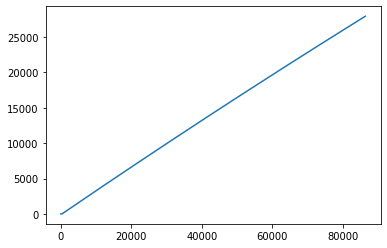

In [ ]:
sol = solve_ivp(extended_model, [0, 60 * 60 * 24], [8, 150, 0, 3, 0], args=extended_model_args() )

plt.plot(sol.t, sol.y[0])